## 1. Environment Setup

First, let's verify we're in the correct conda environment and have all dependencies.

In [1]:
import sys
import os

# Check conda environment
conda_env = os.environ.get('CONDA_DEFAULT_ENV', 'Not detected')
print(f"🐍 Python: {sys.version.split()[0]}")
print(f"📦 Conda Environment: {conda_env}")

# Check GPU
import torch
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🎮 CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

🐍 Python: 3.10.19
📦 Conda Environment: robobrain2-env
🔥 PyTorch: 2.7.0+cu126
🎮 CUDA Available: True
   GPU: NVIDIA GeForce RTX 2060
   Memory: 6.0 GB


In [2]:
# Add scripts directory to path
import pathlib
NOTEBOOK_DIR = pathlib.Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'Notebooks' else NOTEBOOK_DIR
SCRIPTS_DIR = PROJECT_ROOT / 'scripts'

if str(SCRIPTS_DIR) not in sys.path:
    sys.path.insert(0, str(SCRIPTS_DIR))

print(f"📁 Project Root: {PROJECT_ROOT}")
print(f"📁 Scripts Dir: {SCRIPTS_DIR}")

📁 Project Root: /home/yasiru/Documents/github/Robobrain-2.0
📁 Scripts Dir: /home/yasiru/Documents/github/Robobrain-2.0/scripts


## 2. Load the Model

We load the RoboBrain model once and reuse it for all conversations. This is more memory-efficient than reloading for each query.

In [3]:
from utils import get_model
from conversation_memory import MultiTurnInference, ConversationMemory

# Load model (uses local weights if available)
print("Loading RoboBrain 2.0 model...")
model, repo_dir = get_model()
print(f"\n✅ Model loaded successfully!")
print(f"📁 RoboBrain repo: {repo_dir}")

Loading RoboBrain 2.0 model...


`torch_dtype` is deprecated! Use `dtype` instead!


Using local weights from: /home/yasiru/Documents/github/Robobrain-2.0/weights
Using device: cuda — model path: /home/yasiru/Documents/github/Robobrain-2.0/weights
Loading Checkpoint ...
Loading Checkpoint ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


Model thinking support: True
✅ Model loaded.

✅ Model loaded successfully!
📁 RoboBrain repo: /home/yasiru/Documents/github/Robobrain-2.0/RoboBrain2.0_lib


## 3. Initialize Multi-Turn Chat

The `MultiTurnInference` class wraps the model and maintains conversation state.

In [4]:
# Initialize the multi-turn chat system
chat = MultiTurnInference(model, repo_dir)

print("✅ Multi-turn chat initialized!")
print(f"   Context mode: {'ON' if chat.use_context else 'OFF'}")
print(f"   Max history turns: {chat.memory.max_turns}")

✅ Multi-turn chat initialized!
   Context mode: ON
   Max history turns: 20


## 4. Demo: Multi-Turn Conversation

Let's have a conversation about an image. Notice how the model remembers previous exchanges!

📷 Image set: http://images.cocodataset.org/val2017/000000039769.jpg


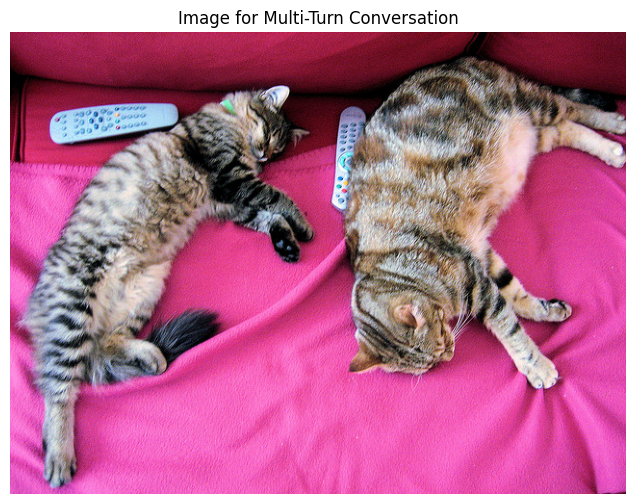

In [5]:
# Set an image to analyze
# Using the classic COCO cats image
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
chat.set_image(image_url)

# Display the image
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Image for Multi-Turn Conversation')
plt.show()

### Turn 1: Initial Question

Let's start by asking what's in the image.

In [6]:
# Turn 1: What's in the image?
result1 = chat.ask(
    "What animals do you see in this image?",
    task="general",
    enable_thinking=False
)

print("👤 User: What animals do you see in this image?")
print(f"🤖 RoboBrain: {result1['answer']}")
print(f"\n📊 Turn number: {result1['turn_number']}")
print(f"📝 Context used: {result1['context_used']}")


==================== INPUT ====================
What animals do you see in this image?

Thinking disabled (but supported).
Running inference ...
👤 User: What animals do you see in this image?
🤖 RoboBrain: 2 cats

📊 Turn number: 2
📝 Context used: False


### Turn 2: Follow-up Question

Now ask a follow-up question. The model should understand we're still talking about the same animals.

In [7]:
# Turn 2: Follow-up (uses context from Turn 1)
result2 = chat.ask(
    "How many of them are there?",
    task="general",
    enable_thinking=False
)

print("👤 User: How many of them are there?")
print(f"🤖 RoboBrain: {result2['answer']}")
print(f"\n📊 Turn number: {result2['turn_number']}")
print(f"📝 Context used: {result2['context_used']}  ← Now using conversation history!")


==================== INPUT ====================
[Previous conversation context]
User (with image): What animals do you see in this image?
Assistant: 2 cats
[Current query]
How many of them are there?

Thinking disabled (but supported).
Running inference ...
👤 User: How many of them are there?
🤖 RoboBrain: 2

📊 Turn number: 4
📝 Context used: True  ← Now using conversation history!


### Turn 3: Another Follow-up

Continue the conversation...

In [8]:
# Turn 3: What are they doing?
result3 = chat.ask(
    "What are they doing?",
    task="general",
    enable_thinking=False
)

print("👤 User: What are they doing?")
print(f"🤖 RoboBrain: {result3['answer']}")


==================== INPUT ====================
[Previous conversation context]
User (with image): What animals do you see in this image?
Assistant: 2 cats
User (with image): How many of them are there?
Assistant: 2
[Current query]
What are they doing?

Thinking disabled (but supported).
Running inference ...
👤 User: What are they doing?
🤖 RoboBrain: 1) They're sleeping on a pink blanket.
2) They're lying down, possibly napping on a pink blanket.
3) They're resting on a pink blanket and a red couch.
4) They're laying on a pink blanket on a sofa.
5) They're sleeping on a pink blanket on a couch.


### Turn 4: Switch to Pointing Task

Now let's switch tasks mid-conversation. We'll ask the model to point at the animals we've been discussing.

In [9]:
# Turn 4: Pointing task (switch task type)
result4 = chat.point_at("the animals we discussed")

print("👤 User: Point to the animals we discussed")
print(f"🤖 RoboBrain: {result4['answer']}")

Pointing task detected. Adding pointing prompt.

==================== INPUT ====================
[Previous conversation context]
User (with image): What animals do you see in this image?
Assistant: 2 cats
User (with image): How many of them are there?
Assistant: 2
User (with image): What are they doing?
Assistant: 1) They're sleeping on a pink blanket.
2) They're lying down, possibly napping on a pink blanket.
3) They're resting on a pink blanket and a red couch.
4) They're laying on a pink blanket on a sofa.
5) They're sleeping on a pink blanket on a couch.
[Current query]
the animals we discussed. Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should indicate the normalized pixel locations of the points in the image.

Thinking enabled.
Running inference ...
👤 User: Point to the animals we discussed
🤖 RoboBrain: [(167, 208), (491, 202), (2

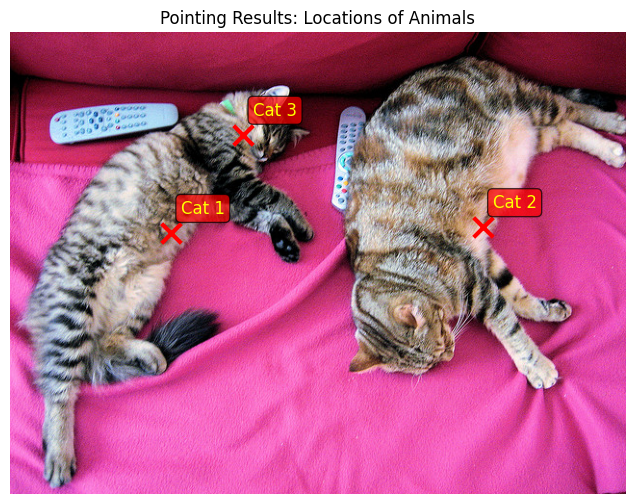

In [10]:
# Visualize the pointing results
import ast

plt.figure(figsize=(10, 6))
plt.imshow(img)

# Parse and plot points
try:
    points = ast.literal_eval(result4['answer'])
    if points:
        xs, ys = zip(*points)
        plt.scatter(xs, ys, c='red', s=200, marker='x', linewidths=3)
        for i, (x, y) in enumerate(points):
            plt.annotate(f'Cat {i+1}', (x, y), xytext=(x+10, y-20), 
                        fontsize=12, color='yellow',
                        bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
except:
    print("Could not parse points from response")

plt.axis('off')
plt.title('Pointing Results: Locations of Animals')
plt.show()

## 5. View Conversation History

Let's see the full conversation history that was maintained.

In [11]:
# Display conversation history
chat.show_history()


📜 CONVERSATION HISTORY

👤 [USER] (Turn 1)
   📷 Image: http://images.cocodataset.org/val2017/000000039769.jpg
   📋 Task: general
   What animals do you see in this image?

🤖 [ASSISTANT] (Turn 2)
   2 cats

👤 [USER] (Turn 3)
   📷 Image: http://images.cocodataset.org/val2017/000000039769.jpg
   📋 Task: general
   How many of them are there?

🤖 [ASSISTANT] (Turn 4)
   2

👤 [USER] (Turn 5)
   📷 Image: http://images.cocodataset.org/val2017/000000039769.jpg
   📋 Task: general
   What are they doing?

🤖 [ASSISTANT] (Turn 6)
   1) They're sleeping on a pink blanket.
2) They're lying down, possibly napping on a pink blanket.
3) They're resting on a pink blanket and a red couch.
4) They're laying on a pink blanket on a sofa.
5...

👤 [USER] (Turn 7)
   📷 Image: http://images.cocodataset.org/val2017/000000039769.jpg
   📋 Task: pointing
   the animals we discussed

🤖 [ASSISTANT] (Turn 8)
   [(167, 208), (491, 202), (242, 106)]



In [12]:
# Get a summary of what we discussed
summary = chat.memory.get_conversation_summary()
print(f"📋 Conversation Summary: {summary}")

📋 Conversation Summary: We've been discussing an image containing: cat. (8 exchanges so far)


## 6. Save & Load Conversations

You can save conversations to continue them later!

In [13]:
# Save the conversation
save_path = str(PROJECT_ROOT / "conversations" / "notebook_demo.json")
chat.save_conversation(save_path)

Conversation saved to /home/yasiru/Documents/github/Robobrain-2.0/conversations/notebook_demo.json


In [14]:
# Create a new chat instance and load the saved conversation
chat2 = MultiTurnInference(model, repo_dir)
chat2.load_conversation(save_path)

print(f"\n✅ Loaded conversation with {len(chat2.memory)} turns")
print(f"📷 Current image: {chat2.memory.current_image}")

Loaded 8 turns from /home/yasiru/Documents/github/Robobrain-2.0/conversations/notebook_demo.json

✅ Loaded conversation with 8 turns
📷 Current image: http://images.cocodataset.org/val2017/000000039769.jpg


In [15]:
# Continue the loaded conversation!
result5 = chat2.ask(
    "Based on our conversation, what color are the cats?",
    task="general",
    enable_thinking=False
)

print("👤 User: Based on our conversation, what color are the cats?")
print(f"🤖 RoboBrain: {result5['answer']}")
print(f"\n✅ Continued from saved conversation! Turn: {result5['turn_number']}")


==================== INPUT ====================
[Previous conversation context]
User (with image): What animals do you see in this image?
Assistant: 2 cats
User (with image): How many of them are there?
Assistant: 2
User (with image): What are they doing?
Assistant: 1) They're sleeping on a pink blanket.
2) They're lying down, possibly napping on a pink blanket.
3) They're resting on a pink blanket and a red couch.
4) They're laying on a pink blanket on a sofa.
5) They're sleeping on a pink blanket on a couch.
User (with image): the animals we discussed
Assistant: [(167, 208), (491, 202), (242, 106)]
[Current query]
Based on our conversation, what color are the cats?

Thinking disabled (but supported).
Running inference ...
👤 User: Based on our conversation, what color are the cats?
🤖 RoboBrain: The cats are brown and black.

✅ Continued from saved conversation! Turn: 10


## 7. Advanced: Grounding with Context

Let's try grounding (bounding box detection) while maintaining conversation context.

🔄 Conversation memory cleared.
📷 Image set: /home/yasiru/Documents/github/Robobrain-2.0/RoboBrain2.0_lib/assets/demo/grounding.jpg


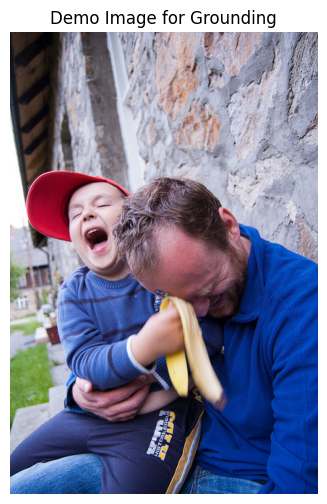

In [16]:
# Start fresh conversation with a different image
chat.reset()

# Use a demo image from the repo
demo_img_path = repo_dir / "assets/demo/grounding.jpg"
if demo_img_path.exists():
    chat.set_image(str(demo_img_path))
    
    # Display the image
    demo_img = Image.open(demo_img_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(demo_img)
    plt.axis('off')
    plt.title('Demo Image for Grounding')
    plt.show()
else:
    print(f"Demo image not found at {demo_img_path}")

In [17]:
# First, ask about the image
r1 = chat.ask("What do you see in this image?", enable_thinking=False)
print(f"🤖 RoboBrain: {r1['answer']}")


==================== INPUT ====================
What do you see in this image?

Thinking disabled (but supported).
Running inference ...
🤖 RoboBrain: man and child eating banana - man covering his face with the banana, both looking happy</think><think>Two people, one adult and one child, sitting on a bench while sharing a funny moment and eating a banana together. The adult has their hand around the child, and the banana is being used as a means to create a humorous situation.</think>A parent and their young child are enjoying a banana together, with the child holding it up and the adult covering their face, creating a playful and lighthearted moment between them.


Grounding task detected. Adding grounding prompt.

==================== INPUT ====================
Please provide the bounding box coordinate of the region this sentence describes: [Previous conversation context]
User (with image): What do you see in this image?
Assistant: man and child eating banana - man covering his face with the banana, both looking happy</think><think>Two people, one adult and one child, sitting on a bench while sharing a funny moment and eating a banana together. The adult has their hand around the child, and the banana is being used as a means to create a humorous situation.</think>A parent and their young child are enjoying a banana together, with the child holding it up and the adult covering their face, creating a playful and lighthearted moment between them.
[Current query]
the person wearing red.

Thinking enabled.
Running inference ...
🤖 Grounding result: An adult dressed in red is holding a child who is also wearing red, standing outside on a sunny day. T

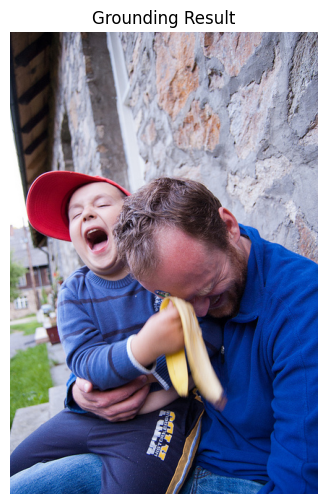

In [18]:
# Now ground a specific object
r2 = chat.ground("the person wearing red")
print(f"🤖 Grounding result: {r2['answer']}")

# Visualize
if demo_img_path.exists():
    plt.figure(figsize=(10, 6))
    plt.imshow(demo_img)
    
    try:
        bbox = ast.literal_eval(r2['answer'])
        if bbox and len(bbox) == 4:
            x1, y1, x2, y2 = bbox
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                 linewidth=3, edgecolor='red', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x1, y1-10, 'Person in red', color='white', fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='red', alpha=0.8))
    except:
        print("Could not parse bounding box")
    
    plt.axis('off')
    plt.title('Grounding Result')
    plt.show()

## 8. Thinking Mode

RoboBrain supports a "thinking" mode where it shows its reasoning process before answering.

In [19]:
# Enable thinking mode
chat.reset()
chat.set_image(image_url)

result_thinking = chat.ask(
    "Describe what's happening in this scene in detail.",
    task="general",
    enable_thinking=True  # Enable thinking!
)

print("👤 User: Describe what's happening in this scene in detail.")
print(f"\n💭 Thinking: {result_thinking.get('thinking', 'N/A')[:500]}...")
print(f"\n🤖 Answer: {result_thinking['answer']}")

🔄 Conversation memory cleared.
📷 Image set: http://images.cocodataset.org/val2017/000000039769.jpg

==================== INPUT ====================
Describe what's happening in this scene in detail.

Thinking enabled.
Running inference ...
👤 User: Describe what's happening in this scene in detail.

💭 Thinking: Two cats are sleeping on top of a couch, occupying most of the available space. Their bodies are almost touching each other, as they both rest comfortably on a pink blanket. There are two remote controls lying on the couch, one towards the left and the other towards the right side, adding to the cozy ambiance of the scene. The overall atmosphere is one of relaxation and warmth as the cats enjoy their nap together....

🤖 Answer: 


## 9. Context Mode Toggle

You can disable context injection if you want each query to be independent.

In [20]:
# Disable context mode
chat.use_context = False
print(f"📝 Context mode: {'ON' if chat.use_context else 'OFF'}")

# This query won't include previous conversation history
r = chat.ask("What do you see?", enable_thinking=False)
print(f"\n🤖 (Without context): {r['answer']}")
print(f"Context used: {r['context_used']}")

# Re-enable context mode
chat.use_context = True
print(f"\n📝 Context mode restored: {'ON' if chat.use_context else 'OFF'}")

📝 Context mode: OFF

==================== INPUT ====================
What do you see?

Thinking disabled (but supported).
Running inference ...

🤖 (Without context): Two cats sleeping on a couch with a pink blanket and two remote controls nearby.
Context used: False

📝 Context mode restored: ON


## 10. API Reference

Here's a quick reference for the `MultiTurnInference` class:

```python
# Initialize
chat = MultiTurnInference(model, repo_dir)

# Set image
chat.set_image("path/to/image.jpg")
chat.set_image("http://example.com/image.jpg")  # URLs work too!

# Ask questions (with context)
result = chat.ask(prompt, task="general", enable_thinking=True)

# Shortcut methods for specific tasks
bbox = chat.ground("the red car")           # Grounding
affordance = chat.get_affordance("grasp")   # Affordance
trajectory = chat.get_trajectory("pick up") # Trajectory
points = chat.point_at("the buttons")       # Pointing

# Conversation management
chat.show_history()                         # Print history
chat.save_conversation("path/to/file.json") # Save
chat.load_conversation("path/to/file.json") # Load
chat.reset()                                # Clear memory

# Settings
chat.use_context = True/False               # Toggle context injection
```